---
title: "Analysis of Hyper-parameters on Single Cell RNA-Seq Data"
format:
    html:
        toc: true
        highlight-style: ayu
---

In [67]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import silhouette_score, silhouette_samples
import scanpy as sc
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.figure_factory as ff


## Getting the Data

We will analyze three types of hyper-parameters: Perplexity on t-SNE and number of clusters chosen from an unsupervised method and how these affect the quality of the selected features.

To performs these three tasks we are gonna work with real data. Specifically, we're gonna use scRNA-Seq data from a brain sample (GSM6900730). The data is available on this [link](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6900730).  

In our case, let's do a basic web scrapping code to get the data.

In [68]:
# download the data and load it for the posterior analysis
import urllib.parse
import requests
import urllib
from bs4 import BeautifulSoup
import os
from ftplib import FTP

url = "https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM6900730"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')
links = table.find_all('a')

download_dir = os.getcwd()

for link in links:
    # Get the URL of the link
    link_url = link.get('href')
    # Check if the link contains 'ftp'
    if link_url and 'ftp' in link_url:
        # Parse the FTP URL
        link_url = urllib.parse.unquote(link_url)
        parsed_url = urllib.parse.urlparse(link_url)
        hostname = parsed_url.hostname
        path = parsed_url.path
        
        # Connect to the FTP server
        ftp = FTP(hostname)
        ftp.login()
        ftp.cwd(os.path.dirname(path))
    
        # Extract the file name from the path
        file_name = os.path.basename(path)
        local_file_path = os.path.join(download_dir, file_name)
        
        with open(local_file_path, "wb") as local_file:
            ftp.retrbinary(f"RETR {file_name}", local_file.write)
    
        ftp.quit()
        print(f"Downloaded {file_name}")
        


Downloaded GSM6900730_JLE16_B1_barcodes.tsv.gz
Downloaded GSM6900730_JLE16_B1_features.tsv.gz
Downloaded GSM6900730_JLE16_B1_matrix.mtx.gz


Now, let's load the data (is a sparse matrix) with `scanpy`:

In [75]:
scdata = sc.read_10x_mtx('D:/Data Analysis Statistical Modeling and Computation in Applications/data/scrnaseq data/',
                         var_names = 'gene_symbols',
                         cache=False)

X_sc = scdata.X.toarray()
print(X_sc.shape)

(5154, 36601)


Ok, now we are gonna tranform the data with (`log(x+1)`) due to the presence of genes with extremely high magnitudes of expression in only a few cells.

In [74]:
X_sc_transformed = np.log2(X_sc + 1)

We can use the principal components analysis to get the top components that explains the 85% variability of the data.

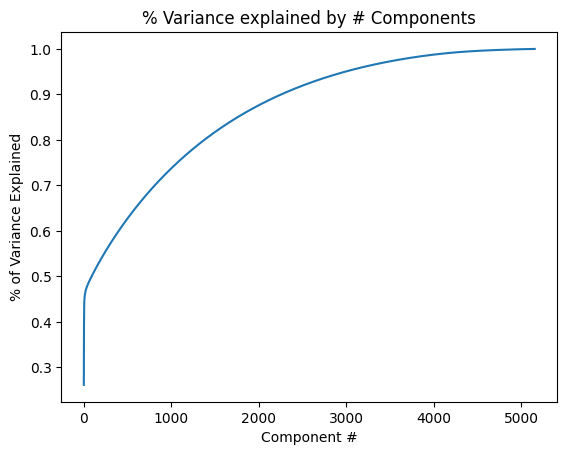

Variance explained 85%: 1758


In [76]:
# PCA

pca = PCA()
pca_axes = pca.fit_transform(X_sc_transformed)


csum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(0,X_sc_transformed.shape[0]),csum)
plt.xlabel('Component #')
plt.ylabel('% of Variance Explained')
plt.title('% Variance explained by # Components')
plt.show()

print(f'Variance explained 85%: {np.where(csum >= 0.85)[0][0]}')


Let's save the number of components on a variable.

In [78]:
top_pca_components = np.where(csum >= 0.85)[0][0]

### Analysis of Perplexities

For the first part of the analysis, we are gonna analyze the following perplexities: 10,20,30,40,50 and see how this change the output of the t-SNE analysis. 

In [80]:
# let's write a helper function for the tsne

def tsne_plotter(data=None,per=40):

    tsne = TSNE(n_components=2, perplexity=per)

    x_tsne = tsne.fit_transform(data)

    ax.scatter(x_tsne[:, 0], x_tsne[:, 1])
    ax.set_xlabel('tSNE 1')
    ax.set_ylabel('tSNE 2')
    ax.set_title(f't-SNE Plot for log2\nTransformed Data, Perplexity:{per}')


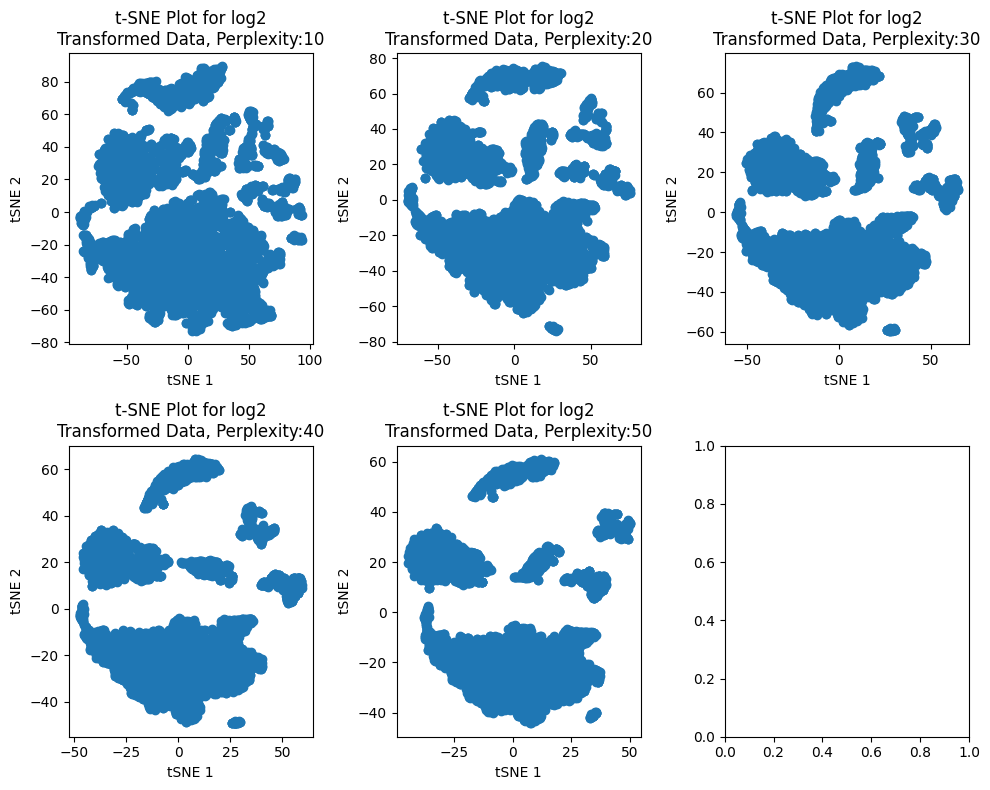

In [81]:
perplexities = [10,20,30,40,50]

num_plots = len(perplexities)
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10,8))

for i,perplexity in enumerate(perplexities):

    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]

    tsne_plotter(pca_axes[:,0:50], per= perplexity)

plt.tight_layout()
plt.show()

We can see that increasing the perplexity values make the clusters more defined. This is in consonance with the definition of the perplexity parameter which says: *“The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results. The perplexity must be less than the number of samples"*. Also, we can notice that from the perplexity value 30 to 50 there are more defined clusters; specifically, for perplexity 50 we see six more defined clusters so, this is the perplexity value chosen for the following analyses.

## Number of Clusters Chosen from an Unsupervised Method

For this part of the analysis on the scRNA-Seq data, we are gonna use the Gaussian Mixture algorithm to get predictec clusters on the data. Then, using these clusters as "labels" we can perform a logistic regression and see how the test score changes when we change the number of clusters.

For this part, we are gonna use the first 50 principal components with the objective of a fast analysis. 

In [88]:
round(csum[:50][-1]*100,2)


48.38

With 50 PC's we achieve ~48% of explained variability.

Now, let's perform the clustering with the GMM model from 2 to 20 clusters. Also, let's plot the BIC (Bayesian Information Criterion) and the Silhouette plot to see how many clusters we can select.

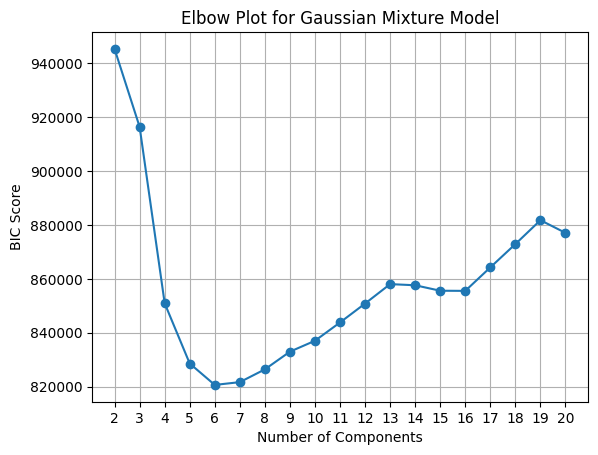

In [93]:
## Clustering elbow plot GMM

n_components_range = range(2, 21)
bic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0, init_params='kmeans')
    gmm.fit(pca_axes[:,0:50])
    # print(f'# comp: {n_components}')
    bic_scores.append(gmm.bic(pca_axes[:,0:50]))

plt.plot(n_components_range, bic_scores, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('Elbow Plot for Gaussian Mixture Model')
plt.xticks(n_components_range)
plt.grid(True)

plt.show()

The BIC score tells us that between 6 and 7 clusters can be a good choice.

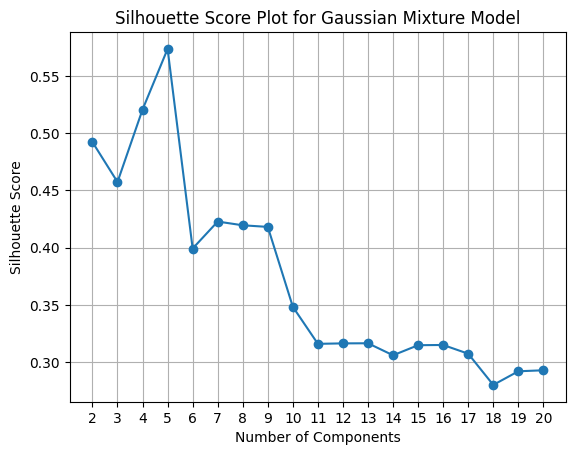

In [94]:
## Silhouette plot
#
n_components_range = range(2, 21)  # Start from 2 components (minimum required for silhouette score)
silhouette_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=0, init_params='kmeans')
    gmm.fit(pca_axes[:, 0:50])
    # print(f'# comp: {n_components}')
    labels = gmm.predict(pca_axes[:, 0:50])
    silhouette_avg = silhouette_score(pca_axes[:, 0:50], labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(n_components_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Plot for Gaussian Mixture Model')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()

The silhouette plot shows that 6, 11 and 18 can be good choices for number of clusters.

Let's work with 6, 7, 8, 11 and 18 clusters andd see how these perform.

### Clusters Analysis

:::{.panel-tabset}

#### Number of clusters: 6

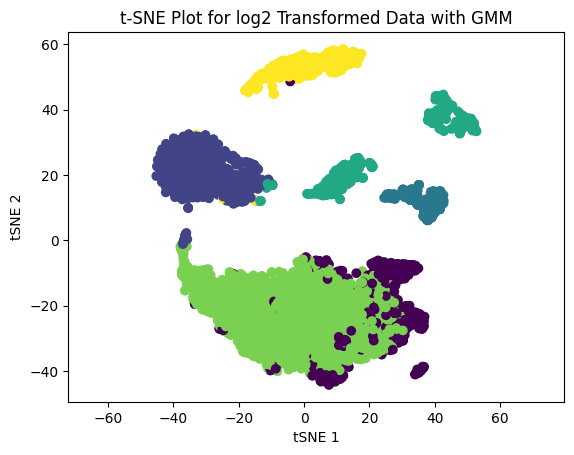

In [95]:
np.random.seed(123)

gmm = GaussianMixture(n_components=6, random_state=0, init_params='kmeans')
clusters_gmm = gmm.fit_predict(pca_axes[:,0:50])

tsne = TSNE(n_components=2, perplexity=50)

x_tsne = tsne.fit_transform(pca_axes[:,0:50])

plt.scatter(x_tsne[:,0], x_tsne[:,1], c=clusters_gmm)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('t-SNE Plot for log2 Transformed Data with GMM')
plt.axis('equal')
plt.show()

In [99]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sc_transformed, clusters_gmm, test_size=0.2, random_state=42)

In [100]:
log_reg = LogisticRegressionCV(cv=10,Cs=[0.01,0.1,1,10],penalty="l1",solver="liblinear",multi_class="ovr")

log_reg.fit(X_train,y_train)

print(f"Train score: {log_reg.score(X_train,y_train)}")
print(f"Test score: {log_reg.score(X_test,y_test)}")

Train score: 0.9932088285229203
Test score: 0.9311348205625606


#### Number of clusters: 7

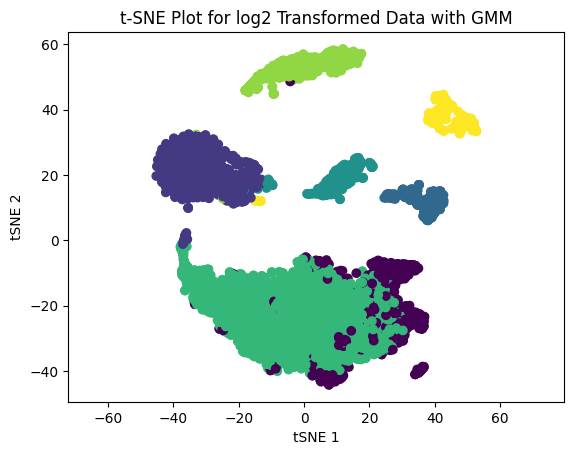

In [101]:
np.random.seed(123)

gmm = GaussianMixture(n_components=7, random_state=0, init_params='kmeans')
clusters_gmm = gmm.fit_predict(pca_axes[:,0:50])

tsne = TSNE(n_components=2, perplexity=50)

x_tsne = tsne.fit_transform(pca_axes[:,0:50])

plt.scatter(x_tsne[:,0], x_tsne[:,1], c=clusters_gmm)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('t-SNE Plot for log2 Transformed Data with GMM')
plt.axis('equal')
plt.show()

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X_sc_transformed, clusters_gmm, test_size=0.2, random_state=42)

In [103]:
log_reg = LogisticRegressionCV(cv=10,Cs=[0.01,0.1,1,10],penalty="l1",solver="liblinear",multi_class="ovr")

log_reg.fit(X_train,y_train)

print(f"Train score: {log_reg.score(X_train,y_train)}")
print(f"Test score: {log_reg.score(X_test,y_test)}")

Train score: 0.9949066213921901
Test score: 0.9321047526673133


#### Number of clusters: 8

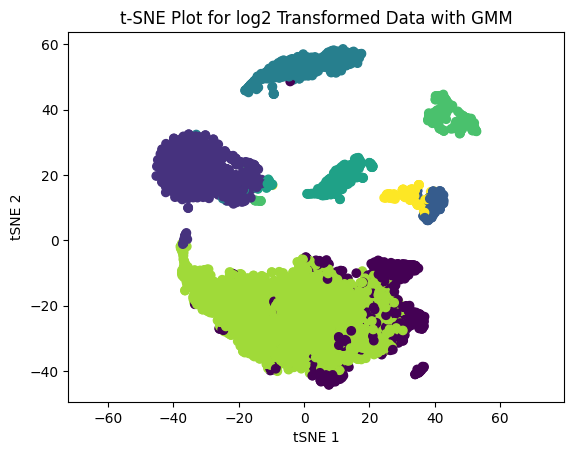

In [104]:
np.random.seed(123)

gmm = GaussianMixture(n_components=8, random_state=0, init_params='kmeans')
clusters_gmm = gmm.fit_predict(pca_axes[:,0:50])

tsne = TSNE(n_components=2, perplexity=50)

x_tsne = tsne.fit_transform(pca_axes[:,0:50])

plt.scatter(x_tsne[:,0], x_tsne[:,1], c=clusters_gmm)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('t-SNE Plot for log2 Transformed Data with GMM')
plt.axis('equal')
plt.show()

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_sc_transformed, clusters_gmm, test_size=0.2, random_state=42)

In [106]:
log_reg = LogisticRegressionCV(cv=10,Cs=[0.01,0.1,1,10],penalty="l1",solver="liblinear",multi_class="ovr")

log_reg.fit(X_train,y_train)

print(f"Train score: {log_reg.score(X_train,y_train)}")
print(f"Test score: {log_reg.score(X_test,y_test)}")

Train score: 1.0
Test score: 0.92725509214355


#### Number of clusters: 11

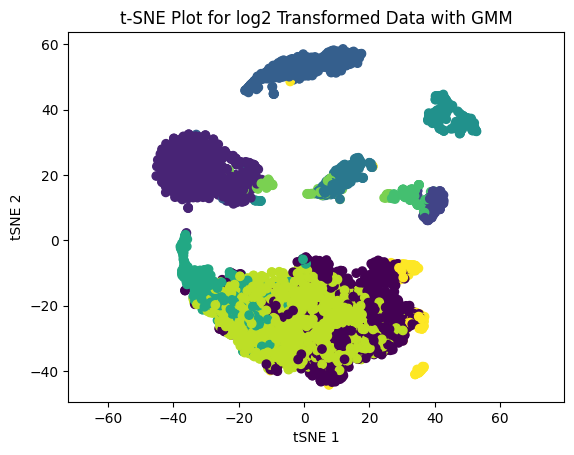

In [107]:
np.random.seed(123)

gmm = GaussianMixture(n_components=11, random_state=0, init_params='kmeans')
clusters_gmm = gmm.fit_predict(pca_axes[:,0:50])

tsne = TSNE(n_components=2, perplexity=50)

x_tsne = tsne.fit_transform(pca_axes[:,0:50])

plt.scatter(x_tsne[:,0], x_tsne[:,1], c=clusters_gmm)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title('t-SNE Plot for log2 Transformed Data with GMM')
plt.axis('equal')
plt.show()

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_sc_transformed, clusters_gmm, test_size=0.2, random_state=42)

In [109]:
log_reg = LogisticRegressionCV(cv=10,Cs=[0.01,0.1,1,10],penalty="l1",solver="liblinear",multi_class="ovr")

log_reg.fit(X_train,y_train)

print(f"Train score: {log_reg.score(X_train,y_train)}")
print(f"Test score: {log_reg.score(X_test,y_test)}")

Train score: 0.9970894979383944
Test score: 0.8079534432589719


:::